### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import tensorflow as tf
tf.__version__

'2.5.1'

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np

#import strawberryfields as sf

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [6]:
fano_data = pd.read_csv("../datasets/signal_080_peak_1_fano_adjust.csv")

In [7]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

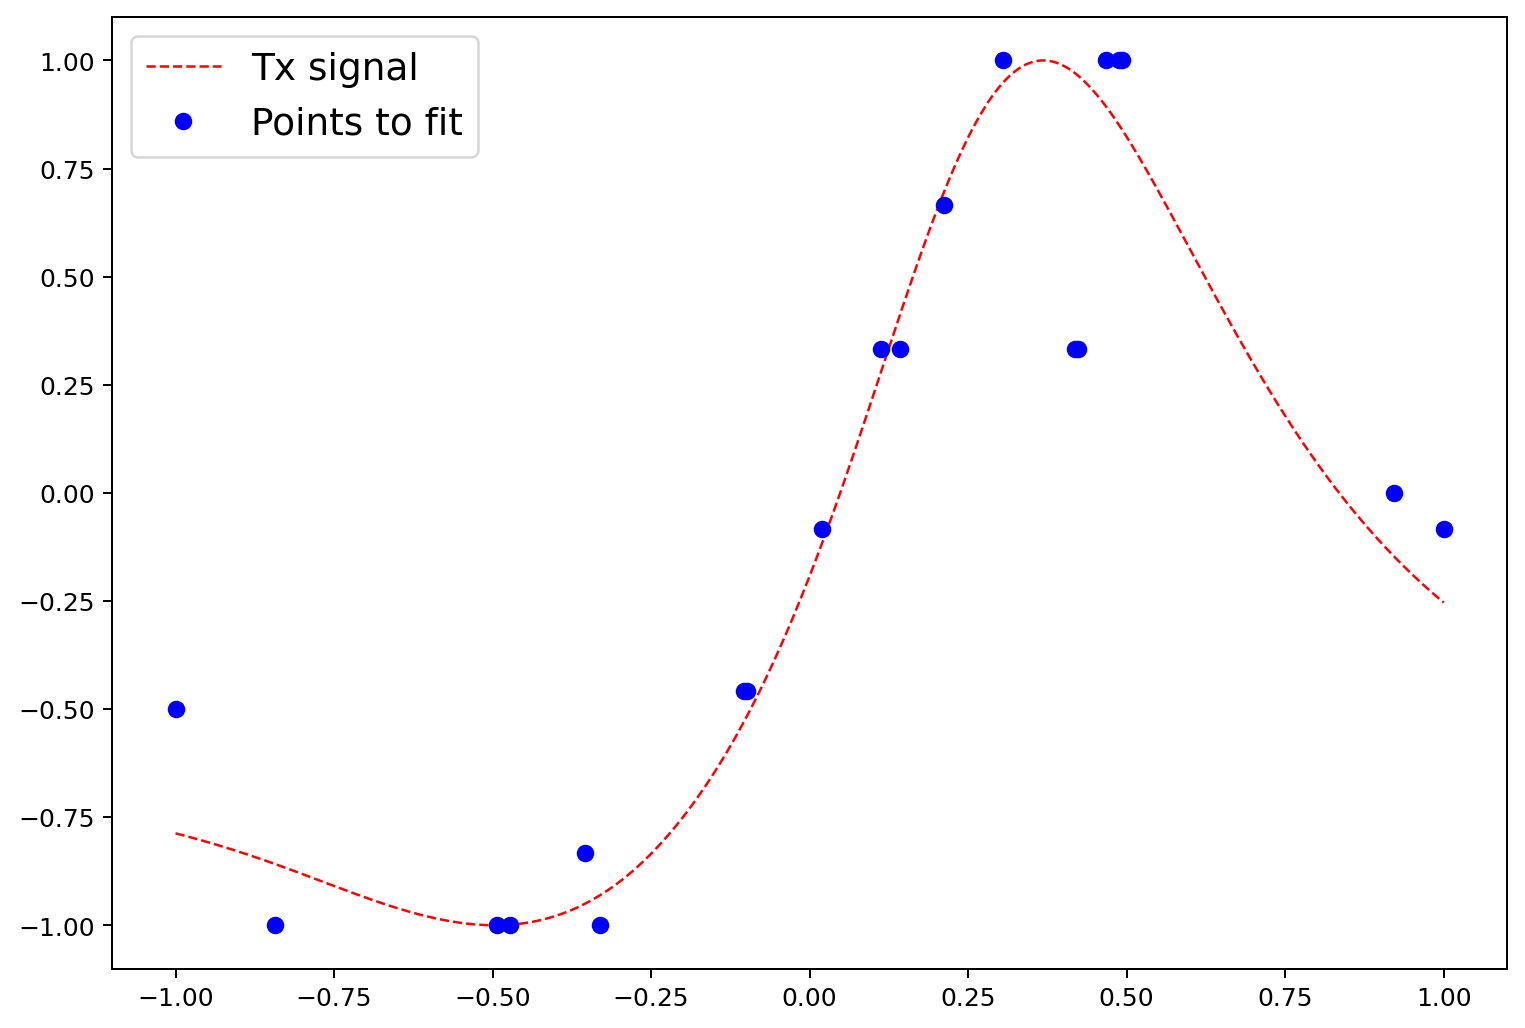

In [9]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X, -1, 1)
y = scale(y, -1, 1)

X_ = scale(X_, -1, 1)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [10]:
TOKEN = ""

In [11]:
#import xcc

#settings = xcc.Settings(REFRESH_TOKEN=TOKEN)
#settings.save()

In [12]:
#sf.store_account(TOKEN)

In [13]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)
#dev = qml.device("strawberryfields.tf", wires=1, cutoff_dim=10)

#dev = qml.device('strawberryfields.remote', backend="X8", shots=10, sf_token=TOKEN)

In [14]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

In [15]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

In [16]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [17]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [36]:
np.random.seed(0)
num_layers = 4
var_init = 0.08 * np.random.randn(num_layers, 5, requires_grad=True)

print(var_init)

[[ 0.14112419  0.03201258  0.07829904  0.17927146  0.14940464]
 [-0.07818223  0.07600707 -0.01210858 -0.00825751  0.03284788]
 [ 0.01152349  0.11634188  0.06088302  0.009734    0.03550906]
 [ 0.02669395  0.11952633 -0.01641266  0.02504542 -0.06832766]]


In [54]:
X_data = np.array(X_.numpy()[:,0], requires_grad=False)
y_data = np.array(y_.numpy(), requires_grad=False)

In [66]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

cost_plot = []

var = var_init
for it in range(100):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.5444409 
Iter:     1 | Cost: 0.4914529 
Iter:     2 | Cost: 0.4593221 
Iter:     3 | Cost: 0.4903462 
Iter:     4 | Cost: 0.5892718 
Iter:     5 | Cost: 0.7646854 
Iter:     6 | Cost: 0.9711015 
Iter:     7 | Cost: 1.2156781 
Iter:     8 | Cost: 1.4944632 
Iter:     9 | Cost: 1.6704229 
Iter:    10 | Cost: 1.8893172 
Iter:    11 | Cost: 2.0531767 
Iter:    12 | Cost: 2.1631306 
Iter:    13 | Cost: 2.2075073 
Iter:    14 | Cost: 2.2391711 
Iter:    15 | Cost: 2.2421002 
Iter:    16 | Cost: 2.2146023 
Iter:    17 | Cost: 2.1252065 
Iter:    18 | Cost: 2.0317092 
Iter:    19 | Cost: 1.8949757 
Iter:    20 | Cost: 1.7218007 
Iter:    21 | Cost: 1.5477727 
Iter:    22 | Cost: 1.3933251 
Iter:    23 | Cost: 1.2372823 
Iter:    24 | Cost: 1.1068446 
Iter:    25 | Cost: 0.9682507 
Iter:    26 | Cost: 0.8496789 
Iter:    27 | Cost: 0.7517393 
Iter:    28 | Cost: 0.7011674 
Iter:    29 | Cost: 0.7049762 
Iter:    30 | Cost: 0.6625670 
Iter:    31 | Cost: 0.6033322 
Iter:   

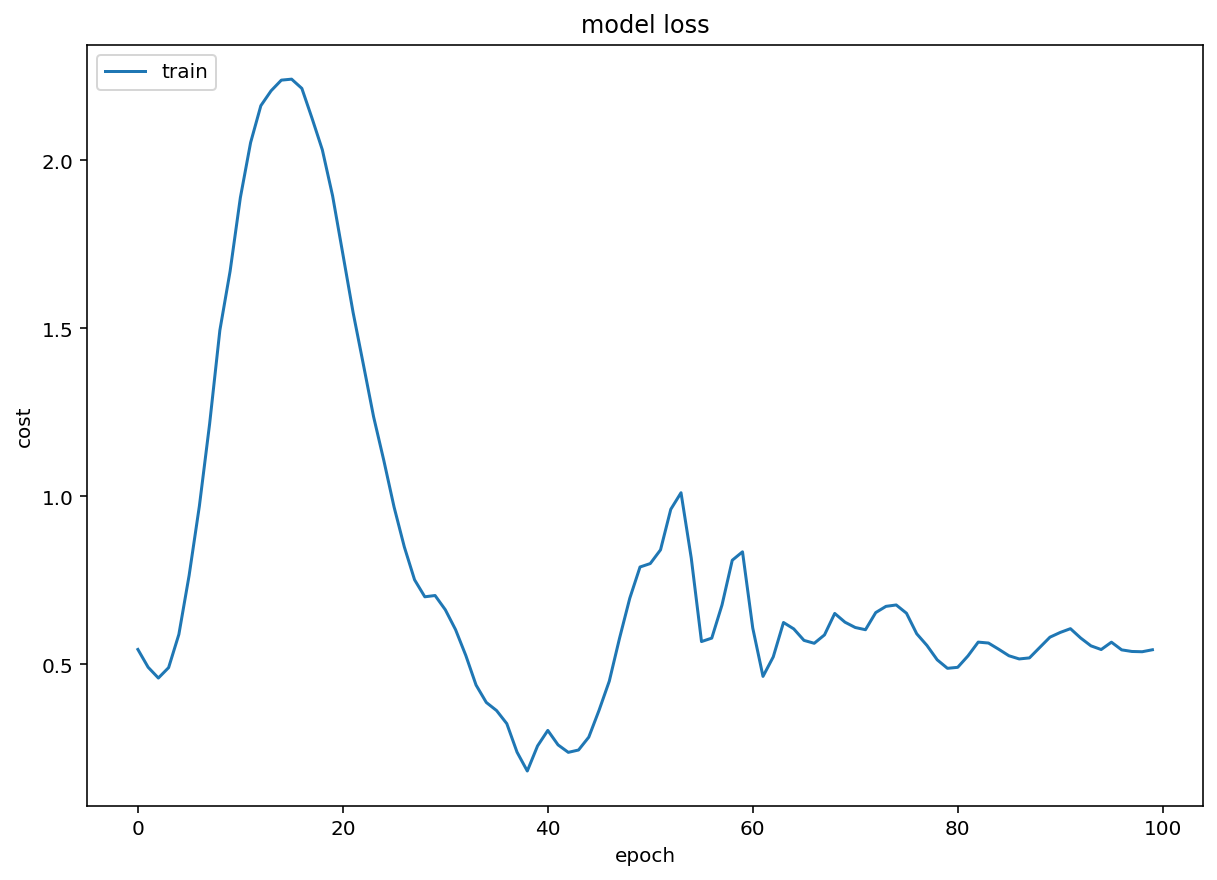

In [67]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [68]:
X_pred = X.numpy()[:,0]

In [69]:
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

In [70]:
y_predict_smooth = smooth(y_predict)

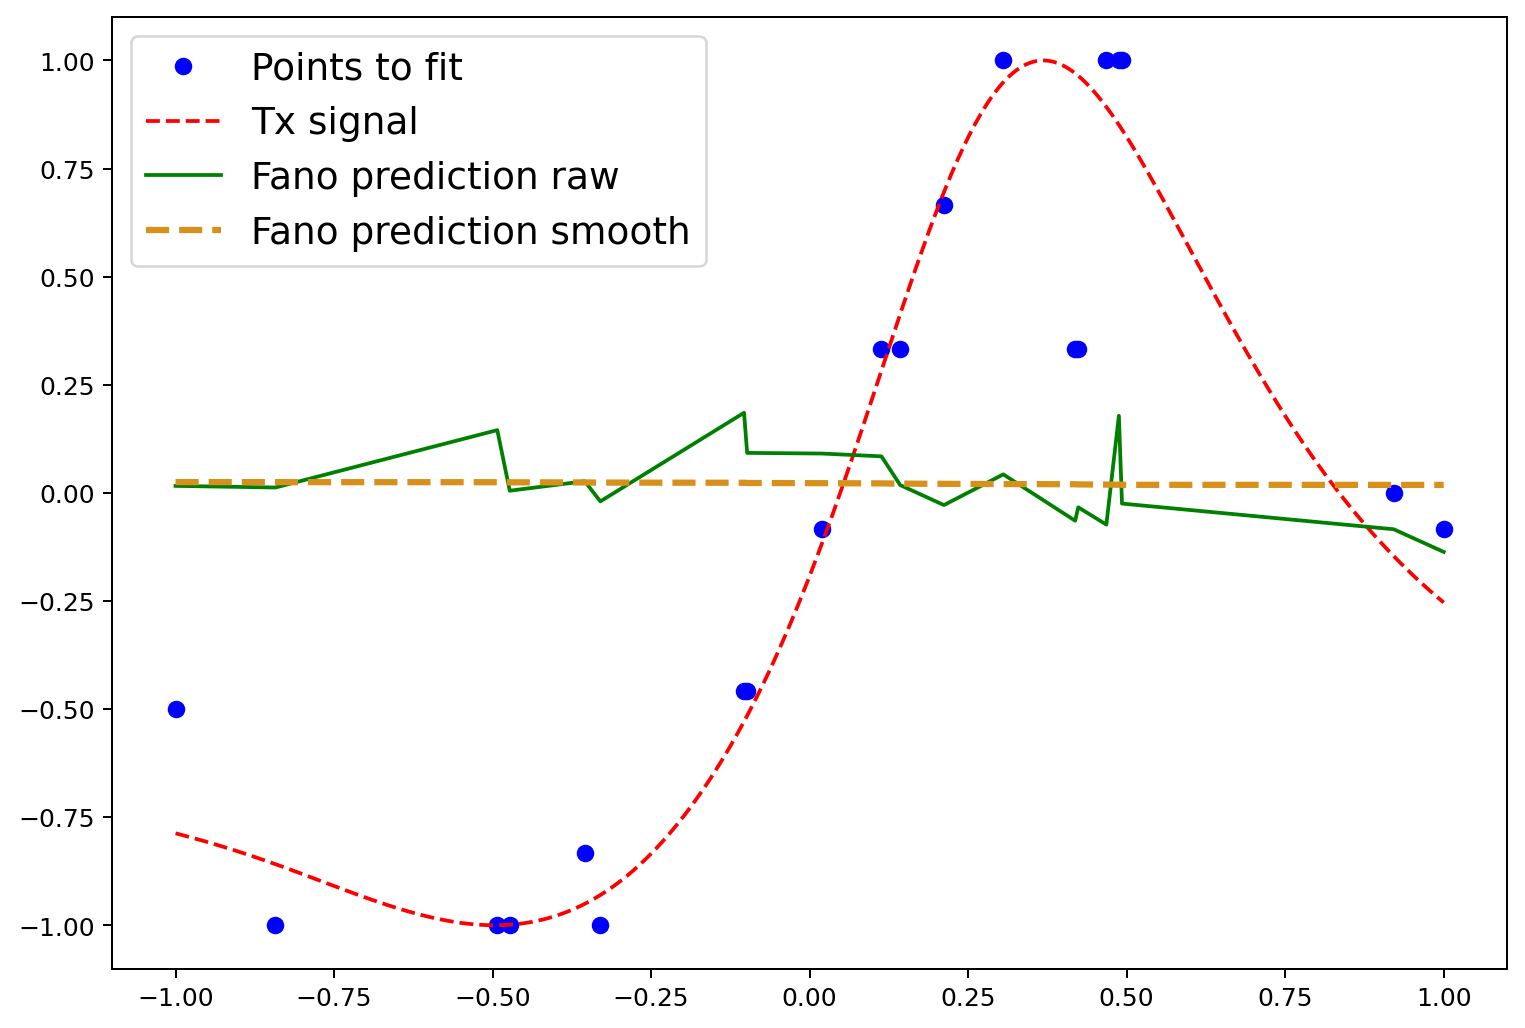

In [71]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

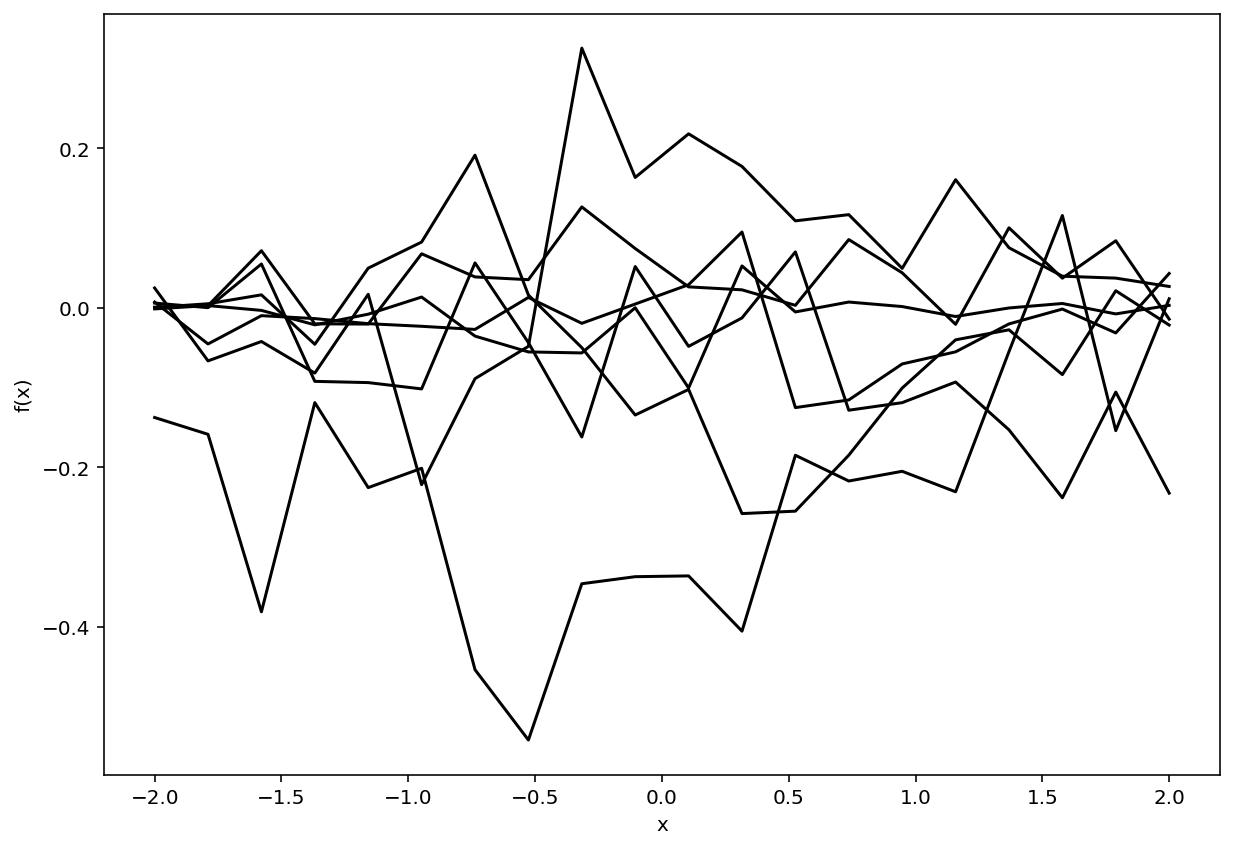

In [72]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 20)

for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
    
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

In [27]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright